# BAYESIAN BERLIN

## Prelimiaries

### Import dependencies

In [15]:
import shapefile
import folium
import json
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sbn

from matplotlib.colors   import LinearSegmentedColormap, rgb2hex

%matplotlib notebook
sbn.set_style("white")

### Define a function for reading files of a given year into a dataframe

In [2]:
def read_from_csv(path, prefix, suffix, year):
    file = path + prefix + str(year) + suffix + '.csv'
    
    data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1', dtype={'RAUMID': str})
    data.sort_values('RAUMID', inplace=True)
    data.rename(columns={'RAUMID':'LOR', 'HK_EU28':'HK_EU27'}, inplace=True)
    data.set_index('LOR', inplace=True)
    data.drop(['ZEIT', 'BEZ', 'PGR', 'BZR', 'PLR', 'STADTRAUM'], axis=1, inplace=True)
    data = data.astype(int)
    
    return data

## Read Datasets

### Set year and path to data here:

In [3]:
year = 2015 # no data available after 2015!
path = './data'

### Read from files and generate data for non-migrants

In [4]:
pop_path = path + '/people/'
geo_path = path + '/geo/'
plr_file = 'RBS_OD_LOR_2015_12'

mb  = read_from_csv(pop_path, 'EWRMIGRA', '12E_Matrix', year)
org = read_from_csv(pop_path, 'EWRMIGRA', '12H_Matrix', year)
tot = read_from_csv(pop_path, 'EWR', '12E_Matrix', year)
dur = read_from_csv(pop_path, 'WHNDAUER', '_Matrix', year)
typ = read_from_csv(pop_path, 'WHNLAGE', '_Matrix', year)

mb.columns = tot.columns
nmb = tot - mb


plrs = shapefile.Reader(geo_path + plr_file)

with open(geo_path + plr_file + '.geojson') as geo_file:
    geo_json = json.load(geo_file)

### Preprocess data sets

In [5]:
dur.insert(loc=2, column='05to10', value=(dur['DAU5'] - dur['DAU10']))
dur.insert(loc=1, column='lt05', value=(tot['E_E'] - dur['DAU5']))
dur.drop(['EINW10', 'EINW5', 'DAU5', 'PDAU10', 'PDAU5'], axis=1, inplace=True)
dur.rename(columns={'DAU10': 'gt10'}, inplace=True)

org.insert(loc=2, column='HK_EUost', value=(org['HK_EU27'] - org['HK_EU15'] - org['HK_Polen']))
org.drop(['HK_EU27'], axis=1, inplace=True)
org.MH_E = nmb.E_E
org.rename(columns={'MH_E': 'De'}, inplace=True)
new_col_names = pd.Index([column[3:] for column in org.columns[1:]])
org.columns = org.columns[:1].append(new_col_names)

mb.drop('E_E', axis=1, inplace=True)
mb.drop(mb.columns[-9:], axis=1, inplace=True)
mb.columns = pd.Index([column[3:].replace('_', 'to').lower() for column in mb.columns])

mb_mf = mb.loc[:, :'w']
mb.drop(['m', 'w'], axis=1, inplace=True)

nmb.drop('E_E', axis=1, inplace=True)
nmb.drop(nmb.columns[-9:], axis=1, inplace=True)
nmb.columns = pd.Index([column[3:].replace('_', 'to').lower() for column in nmb.columns])

nmb_mf = nmb.loc[:, :'w']
nmb.drop(['m', 'w'], axis=1, inplace=True)

typ.columns = pd.Index([column[2:] for column in typ.columns])

del tot

## Generate Conditional Probabilities and Prior

In [41]:
p_dur = dur.apply(lambda x: x / x.sum(), axis=1)
p_org = org.apply(lambda x: x / x.sum(), axis=1)
p_mb  =  mb.apply(lambda x: x / x.sum(), axis=1)
p_nmb = nmb.apply(lambda x: x / x.sum(), axis=1)
p_typ = typ.apply(lambda x: x / x.sum(), axis=1)

p_mb_mf  = mb_mf.apply(lambda x: x / x.sum(), axis=1)
p_nmb_mf = nmb_mf.apply(lambda x: x / x.sum(), axis=1)

prior = dur.sum(axis=1) / dur.sum(axis=1).sum()
prior.name = 'prior'

## Input Your Data Here

**duration**: 'lt05', '05to10', 'gt10'

**origin**: 'De', 'EU15', 'EUost', 'Polen', 'EheJug', 'EheSU', 'Turk', 'Arab', 'Sonst', 'NZOrd'

**age**: '00to01', '01to02', '02to03', '03to05', '05to06', '06to07', '07to08', '08to10', '10to12', '12to14', '14to15', '15to18', '18to21', '21to25', '25to27', '27to30', '30to35', '35to40', '40to45', '45to50', '50to55','55to60', '60to63', '63to65', '65to67', '67to70', '70to75', '75to80', '80to85', '85to90', '90to95', '95to110'

**sex**: 'm', 'w'

**crib**: 'EINFoL', 'EINFmL', 'MIToL', 'MITmL', 'GUToL', 'GUTmL', 'NZORD'

If your age is smaller than the duration you have lived in your Kiez, then the probability of you living anywhere in Berlin (or of even existing, for that matter) is exactly zero. We do not catch this case explicitly here.

In [26]:
duration = '05to10'
origin   = 'Sonst'
age      = '25to27'
sex      = 'w'
crib     = 'EINFmL'

## Compute Posterior Probability Distribution

In [27]:
if origin == 'De':
    p_age = p_nmb
    p_sex = p_nmb_mf
else:
    p_age = p_mb
    p_sex = p_mb_mf

In [28]:
posterior = prior.copy()
kieznames = prior.copy()

for plr in plrs.iterShapeRecords():
    plr_id = plr.record[0]
    kieznames.loc[plr_id] = plr.record[1] 
    likelihood = (p_dur.loc[plr_id, duration] * p_age.loc[plr_id, age] * 
                  p_sex.loc[plr_id, sex] * p_org.loc[plr_id, origin] * p_typ.loc[plr_id, crib])
    posterior.loc[plr_id] = likelihood * prior.loc[plr_id]    

posterior = posterior / posterior.max()

## Visualize Results

### PLR-resolved posterior probability onto Berlin map

In [11]:
berlin = (52.521918, 13.413215)
kiezes = folium.FeatureGroup(name='Probability')

clist = ['white']
clist.extend([plt.cm.Blues(x) for x in np.arange(0.2, 1.2, 0.2)])
c_map = LinearSegmentedColormap.from_list('WhiteOrange', clist)
f_map = folium.colormap.LinearColormap(clist, vmin=0.0, vmax=1.0, caption='Relative Probability')

for plr in geo_json['features']:
    plr_id = plr['properties']['PLR']
    probab = posterior[plr_id]
    pcolor = rgb2hex(c_map(probab)[:3])
    plr['properties'].update({'FILL': pcolor})
    plr_style = lambda plr: {'fillOpacity': 0.6,
                               'fillColor': plr['properties']['FILL'],
                                   'color': 'black',
                                  'weight': 1.0}
    
    name = kieznames[plr_id] + ': ' + '{:.2f}'.format(probab)
    kiez = folium.GeoJson(plr, style_function=plr_style)
    kiez.add_child(folium.Popup(name))
    kiez.add_to(kiezes)

map = folium.Map(location=berlin)
map.add_child(kiezes)
map.add_child(f_map)
map.add_child(folium.LayerControl())

### Bar-plot of _top-ten_ hits

<IPython.core.display.Javascript object>


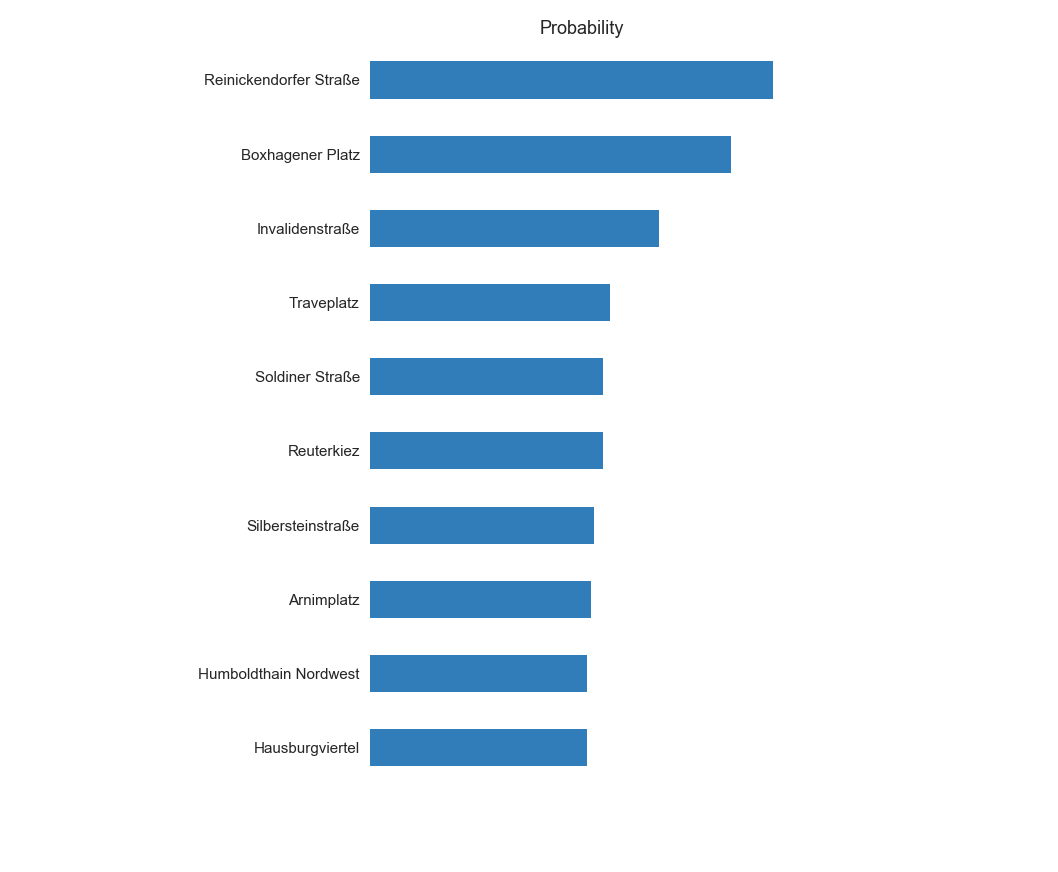

In [31]:
top10 = posterior.sort_values(ascending=False).iloc[:10]

fig = plt.figure(num=2, figsize=(9.7, 8))
ax = fig.add_axes([0.35, 0.1, 0.4, 0.85])
top10.plot.barh(color=c_map(0.7), ax=ax)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_yticklabels(kieznames.loc[top10.index])
ax.set_xticklabels('')
ax.set_title('Probability')
sbn.despine(left=True, bottom=True)